[SOM网络原帖](https://zhuanlan.zhihu.com/p/174836784)

一、基础概念：

SOM（Self-Organizing Feature Map, 自组织特征映射神经网络，也称Kohonen网络）。SOM网络是一种无监督学习算法。SOM网络结构比较简单，只有输入层和输出层（输出层我们通常也称为竞争层），在竞争层，神经元可以排列形成多种形式。每个样本都可以映射到与其距离最小的竞争层神经元上，最终在竞争层生成一个低维、离散的映射。

二、与经典BP区别与联系

不同于一般神经网络基于损失函数的优化训练，SOM运用竞争学习策略逐步优化网络。其聚类的基本思想和KMeans算法相似，都是将距离小的个体集合划分为同一类别，将距离大的个体集合划分为不同的类别。SOM网络有一个特点在于竞争层的映射保留了原数据的拓扑结构。其样本之间的相对距离保持不变，举例来说原数据距离最近或者最远的，在新的映射下的距离还是最近或者最远的。具体我们也会在下面的代码画图给大家看下。
总的来说，SOM网络包含初始化、竞争、迭代三块内容。




SOM网络的拓扑结构如下图：

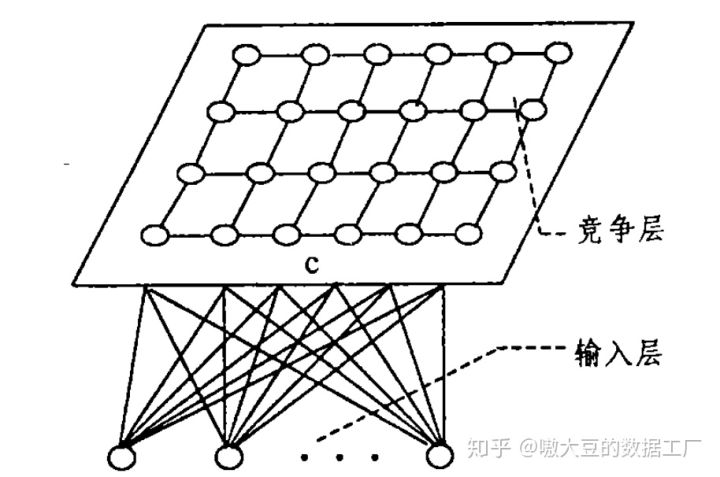

二、功能及Python实现

在代码这部分中，有以下几项内容：

1、Python手写实现SOM网络。

2、利用自己手写的类对一个二维数据集进行聚类分析。

3、利用自己手写的类和第三方库minisom，分别对鸢尾花的数据进行映射，并查看映射后的拓扑关系。


In [3]:
import numpy as np
import os
#os.chdir(r"D:\mywork\test")

# 首先，构造一个SOM类。
class SOMnetwork(object):
    """
    Self-Organizing Feature Map
    """
    def __init__(self, maxRound, minRound, maxRate, minRate, Iters):
        self.maxRound = maxRound
        self.minRound = minRound
        self.maxRate = maxRate
        self.minRate = minRate
        self.steps = Iters
        
        self.RateList = []                  #存放每轮迭代学习率的容器
        self.RoundList = []                 #存放每轮迭代优胜半径的容器
        self.X = 0                          #训练数据集
        self.normX = 0                      #归一化后的数据集
        
        self.gridLocation = 0               #竞争层的神经元节点位置坐标
        self.w = 0                          #神经元节点权重
        self.gridDist = 0                   #神经元节点之间的距离

# 然后我们设置了一些函数，包括：归一化原始数据函数、计算欧式距离函数、计算各个神经元节点之间距离的函数、初始化竞争层节点权重函数。
        #归一化函数
    def normalize(self,X):
        return (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
    
    
    #计算欧式距离函数
    def edist(self,X1,X2):
        return (np.linalg.norm(X1-X2))
    
    
    #计算各个节点之间的距离
    def calGdist(self, grid):
        m = len(grid)
        Gdist = np.zeros((m,m))
        for i in range(m):
            for j in range(m):
                if i != j:
                    Gdist[i,j] = self.edist(grid[i], grid[j])
        return Gdist


    #初始化竞争层
    def init_grid(self,M,N):
        grid = np.zeros((M*N,2))      #分成M*N类，两个维度
        k = 0
        for i in range(M):
            for j in range(N):
                grid[k,:] = np.array([i,j])
                k += 1
        return grid

# 在这里我们还设置了学习率和优胜半径的递减函数。
        #学习率和优胜半径的递减函数
    def changeRate(self,i):
        Rate = self.maxRate - (self.maxRate-self.minRate)*(i+1)/self.steps
        Round = self.maxRound - (self.maxRound-self.minRound)*(i+1)/self.steps
        return Rate, Round

# 接着是模型训练的主体部分，用来训练得出最终的竞争层的神经元节点的权重。在这里为了简化计算这里暂不考虑节点的更新约束。
    #开始训练
    def train(self, X, M, N):
        self.X = X
        ##标准化数据集
        X = self.normalize(X)
        n_samples, n_features = X.shape
        ##1 初始化
        ###各个节点位置，以及各节点之间的位置
        self.gridLocation = self.init_grid(M,N)
        self.gridDist = self.calGdist(self.gridLocation)
        ###初始化各个节点对应的权值
        w = np.random.random((M*N, n_features))
        ###确定迭代次数，不小于样本数的5倍
        if self.steps<5*n_samples:
            self.steps = 5*n_samples
        for i in range(self.steps):
            ##2 竞争
            ###随机选取样本计算距离
            data = X[np.random.randint(0, n_samples, 1)[0], :]
            Xdist = [self.edist(data,w[row]) for row in range(len(w))]
            ###找到优胜节点
            winnerPointIdx = Xdist.index(min(Xdist))
            ##3 迭代
            ###确定学习率和节点优胜半径，并保存
            Rate, Round = self.changeRate(i)
            self.RateList.append(Rate)
            self.RoundList.append(Round)
            ###圈定优胜邻域内的所有节点
            winnerRoundIdx = np.nonzero(self.gridDist[winnerPointIdx]<Round)[0]
            ###对节点权值进行调整，为了简化运算这里暂不考虑节点的更新约束
            w[winnerRoundIdx] = w[winnerRoundIdx] + Rate*(data-w[winnerRoundIdx])
        self.w = w
        self.normX = X

# 最后少不了聚类的函数，根据训练出来的权重，将数据集进行聚类。
    #聚类标签
    def cluster(self, X):
        X = self.normalize(X)
        m = X.shape[0]
        cluster_labels = []
        for i in range(m):
            yi = np.linalg.norm((X[i] - self.w), axis=1)
            cluster_labels.append(yi.argmin())
        return np.array(cluster_labels)


其次我们利用手写的SOM网络类来对数据集进行聚类测试。

我们先导入数据，看下分布。我们发现这样的数据做出来的结果好坏应该很好分辨。


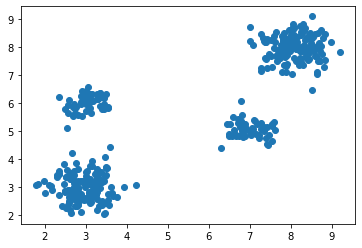

In [5]:
if __name__ == "__main__":
    #####################################################
    #                                                   #
    #        自编的SOM网络对二维数据进行聚类测试          #
    #                                                   #
    #####################################################
    #用于聚类的数据准备
    with open("/content/somSet.txt") as f:
        trainSet = f.readlines()
    trainSet = np.array([line.split("\t") for line in trainSet]).astype(float)
    #查看下数据分布
    import matplotlib.pyplot as plt
    plt.scatter(trainSet[:,0], trainSet[:,1])
    plt.show()

接着我们进行训练，并再次画图验证聚类结果。我们发现聚类结果正确无误。

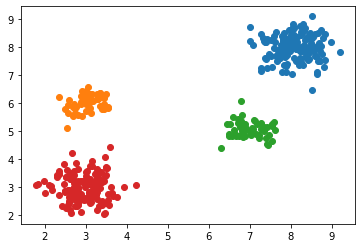

In [7]:
    #正式SOM聚类
    som_self = SOMnetwork(5, 0.1, 0.5, 0.01, 1000)
    som_self.train(trainSet, 2, 2)
    som_self_cluster = som_self.cluster(trainSet)
    #再次画图验证聚类结果
    for cc in set(som_self_cluster):
        plt.scatter(trainSet[som_self_cluster==cc,0], trainSet[som_self_cluster==cc,1])
    plt.show()

最后我们需要通过自编的SOM网络和minisom第三方库中的SOM网络分别对鸢尾花数据集（IRIS）进行聚类映射，并查看其映射后结果在二维平面上的拓扑结构。

In [31]:
    #####################################################
    #                                                   #
    #    自编的SOM网络和minisom第三方库测试iris数据集     #
    #                                                   #
    #####################################################
    #导入Iris数据集
    from sklearn.datasets import load_iris
    iris = load_iris()
    X = iris.data
    y = iris.target

    #自编的SOM网络对Iris进行6*6的映射
    n = 6
    som_self = SOMnetwork(5, 0.1, 0.5, 0.01, 1000)
    som_self.train(X, n, n)
    som_self_cluster = som_self.cluster(X)
    som_grid = som_self.gridLocation
    som_grid_Idx = [(som_grid[i,0], som_grid[i,1]) for i in range(som_grid.shape[0])]

我们看下映射后的拓扑结构图。

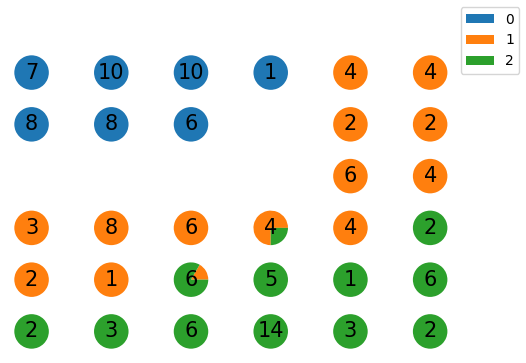

In [32]:
    import matplotlib.pyplot as plt

    def draw(y, cluster, m, n, gridLocation):
        yset = np.unique(y)
        fig = plt.figure(dpi=100)
        for i in range(gridLocation.shape[0]):
            labelisi = sum(cluster==i)
            if labelisi > 0:
                #统计映射后的每个真实标签的个数
                yi = y[cluster==i]
                yiCount = np.bincount(yi)
                #统计比率
                if yiCount.size < yset.size:
                    yiCount = yiCount.tolist() + [0]*(yset.size-yiCount.size)
                yiRatio = yiCount/labelisi
                plt.subplot(n, n, i+1)
                plt.pie(yiRatio)
                plt.text(x=0, y=0, s=str(labelisi), fontsize=15, horizontalalignment='center', verticalalignment='center')
        fig.legend(yset)
        plt.show()

    #自编的SOM网络结果画平面的拓扑图
    draw(y, som_self_cluster, n, n, som_grid)


数据集一共有3种（0 1 2）鸢尾花，我们人为定义了聚类结果为36类。每个圆形代表一类。数字为这一类的鸢尾花数量。同一个圆形不止一种颜色是因为两种不同的鸢尾花被聚到了同一类。

通过图，我们可以发现2点：

第一点是，虽然我们预设了6*6，共36类，但是我们可以发现，有几个节点是没有样本的（空白的区域）.这就是SOM网络特殊的地方，在Kmeans中一般我们指定了K类，最终大概率会有K类聚类的返还，但在SOM网络中由于其自身的适应性，会自动调整聚类结果。

第二点是，映射后的新的数据的确会保留数据原有的拓扑结构，同种鸢尾花的类都是挨在一起的。

最后我们也看下第三方库minisom的聚类结果

首先需要安装minisom第三方库


In [39]:
pip install minisom

聚类结果

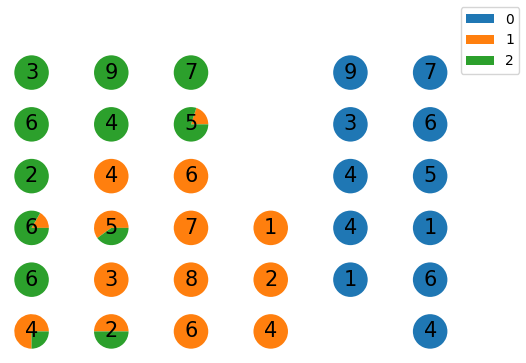

In [40]:
    #minisom第三方库的结果
    from minisom import MiniSom   
    som_minisom = MiniSom(n, n, X.shape[1])
    som_minisom.train_random(X, 1000)
    som_minisom_cluster = np.array([som_grid_Idx.index(list(som_minisom.win_map(np.expand_dims(X[i],0)).keys())[0]) for i in range(X.shape[0])])
    #minisom第三方库的SOM网络结果画平面的拓扑图
    draw(y, som_minisom_cluster, n, n, som_grid)